In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time 
import csv
import os
from pprint import pprint
from pandas.io.json import json_normalize

In [3]:
# import csv file that is a breakdown of cases and deaths per day by state and county
df = pd.read_csv("CSV Folder/us-counties.csv.txt")

#group by state and date so that data is no longer at the county level, but at the state level
state_df = df.groupby(["state","date"])

#Create a data frame that has total cases by date by state
cases = state_df["cases"].sum()
workable_df = pd.DataFrame(cases)
workable_df = workable_df.reset_index()

#get the data for deaths per state per day into a series format to add to the cases dataframe
deaths = state_df["deaths"].sum()
death=pd.DataFrame(deaths)
work_death=death.reset_index()
DEAD = work_death["deaths"]

# Add Deaths column to the cases dataframe
workable_df["Deaths"]=DEAD

#Create final dataframe with just the columns we are interested in
final_df = workable_df[["date","state","cases","Deaths"]]

#Sort final df by date and re-index
final_df = final_df.sort_values("date")
final_df = final_df.reset_index(drop = True)

In [4]:
#Liz's Hospital Dataframe



#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)



In [5]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [6]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5231,43295,NaN,48526,NaN,NaN,177.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,329,10790,NaN,11119,168.0,42.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5251,49901,NaN,55152,1155.0,637.0,208.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,2227,25214,NaN,27441,809.0,86.0,43.0,106,106,106,40,100,46,45,49,5,1
4,California,33261,266839,NaN,300100,NaN,4886.0,1268.0,466,466,466,302,401,18,15,44,16,-17


In [7]:
deathsbyState = comb2_df.loc[:,["State","Total Deaths"]]
deathsbyState.sort_values("Total Deaths", ascending = False,inplace = True)
deathsbyState["Percent of Deaths in US"]=round(deathsbyState["Total Deaths"]/deathsbyState["Total Deaths"].sum()*100,2)
deathsbyState.reset_index(drop = True)
USDeaths = deathsbyState["Total Deaths"].sum()
deathsbyStatePie = deathsbyState[deathsbyState["Percent of Deaths in US"]>1]
PercentTop = deathsbyStatePie["Percent of Deaths in US"].sum()
PercentOther = (100 - float(PercentTop))
OtherDeaths = USDeaths - deathsbyStatePie["Total Deaths"].sum()
print(deathsbyStatePie["Total Deaths"].sum())
print(OtherDeaths)
print(f" Total deaths in us is {USDeaths} and the percent of states with less than 1% is {PercentOther}")
Chart = deathsbyStatePie.append({"State":"Others","Total Deaths":OtherDeaths,"Percent of Deaths in US":PercentOther}, ignore_index = True)

36414.0
3395.0
 Total deaths in us is 39809.0 and the percent of states with less than 1% is 8.510000000000005


In [8]:
Chart

,State,Total Deaths,Percent of Deaths in US
0,New York,14828.0,37.25
1,New Jersey,4753.0,11.94
2,Michigan,2700.0,6.78
3,Massachusetts,1961.0,4.93
4,Pennsylvania,1564.0,3.93
5,Illinois,1468.0,3.69
6,Connecticut,1423.0,3.57
7,Louisiana,1405.0,3.53
8,California,1268.0,3.19
9,Florida,856.0,2.15


Text(0.5, 1, 'Deaths in the US by State')

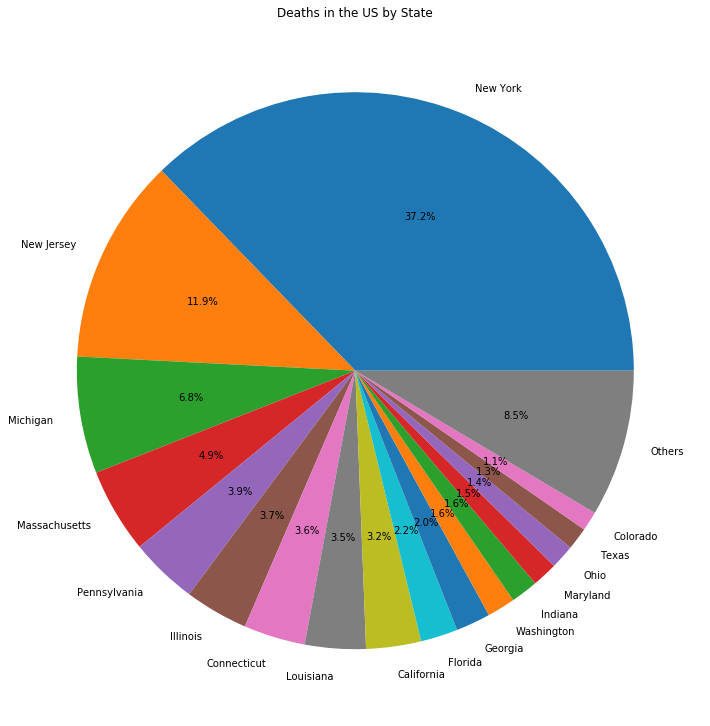

In [15]:
labels = Chart["State"]
sizes = Chart ["Total Deaths"]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()
plt.title("Deaths in the US by State")
plt.legend( loc = 'upper left', )

In [21]:
cases=final_df.pivot( index="date",columns="state",values = "cases")
cases = cases.fillna(0)

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 2880x720 with 0 Axes>

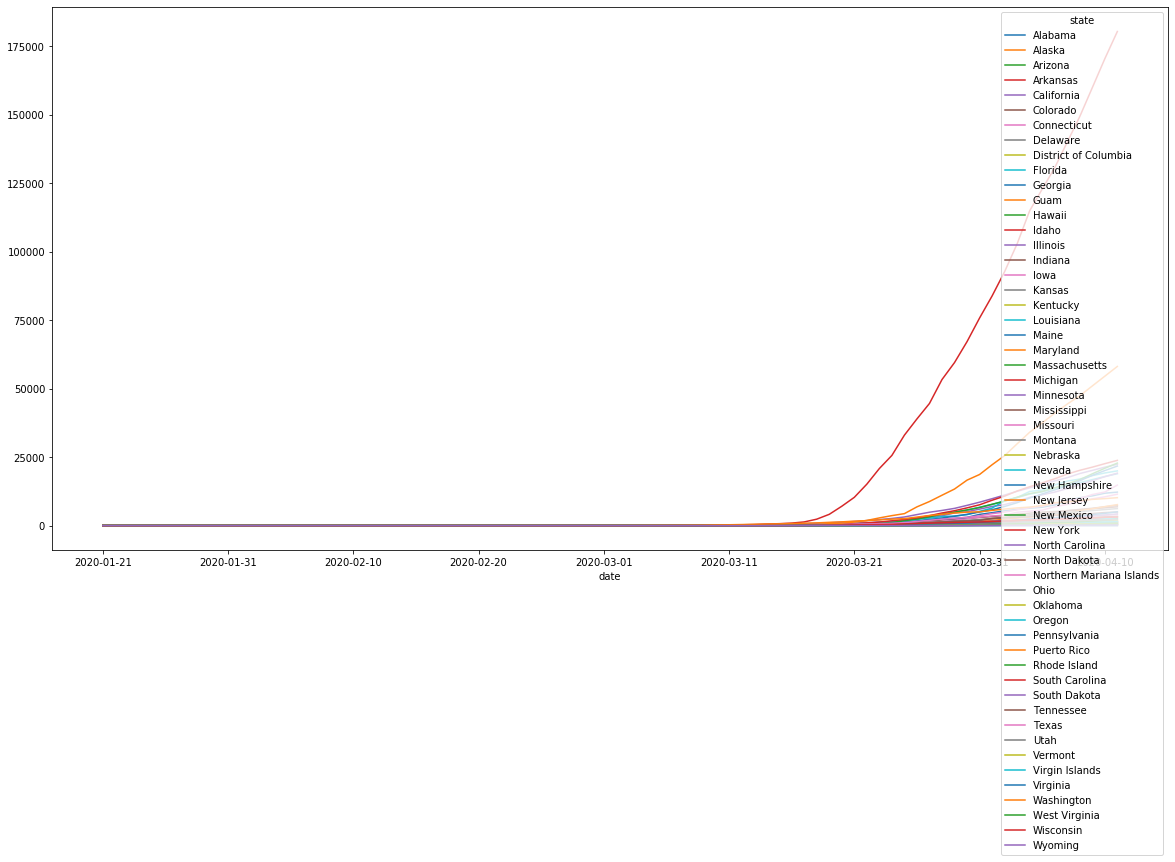

In [26]:

cases.plot.line(figsize = (20,10))
plt.show

In [31]:
date_group = final_df.groupby("date")

In [34]:
date_group.sum().head(40)

,cases,Deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0
2020-01-26,5,0
2020-01-27,5,0
2020-01-28,5,0
2020-01-29,5,0


<function matplotlib.pyplot.show(*args, **kw)>

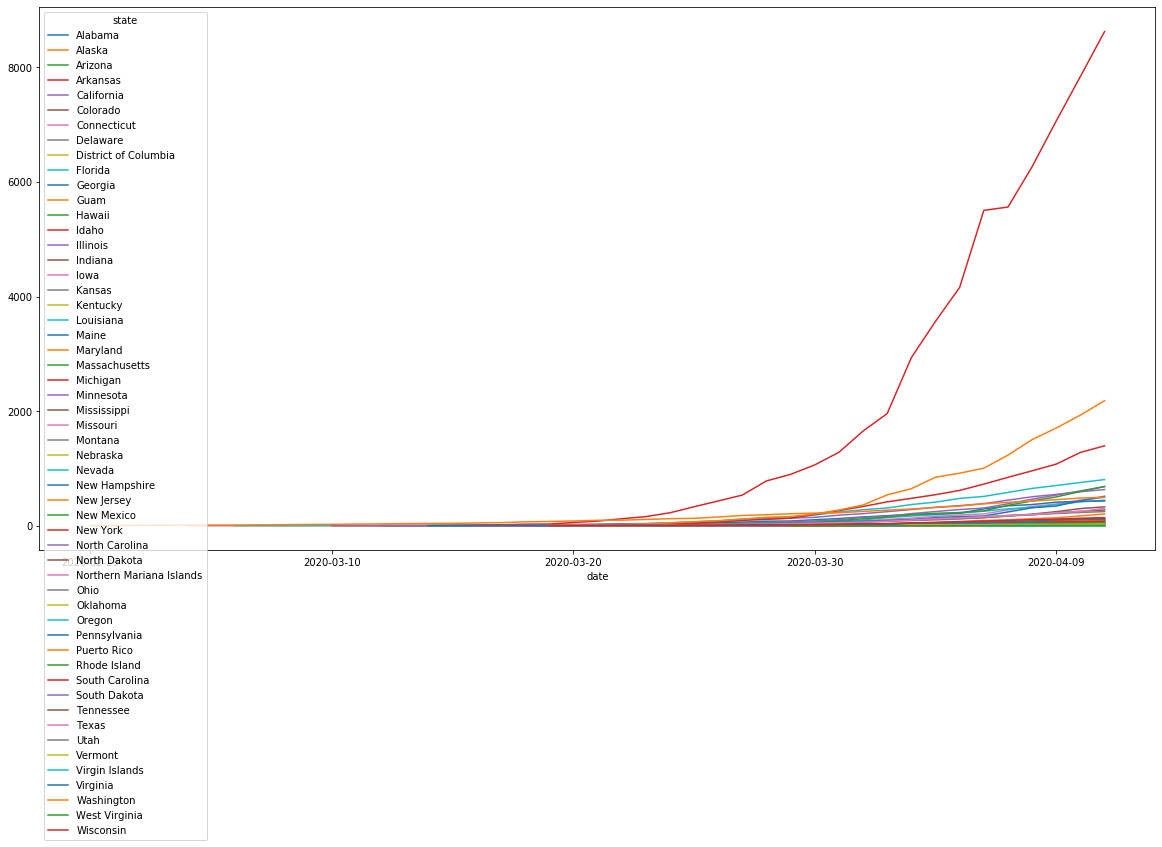

In [39]:
death_df = final_df[final_df["Deaths"]>0]
death_plot = death_df.pivot( index="date",columns="state",values = "Deaths")
death_plot.plot.line(figsize = (20,10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

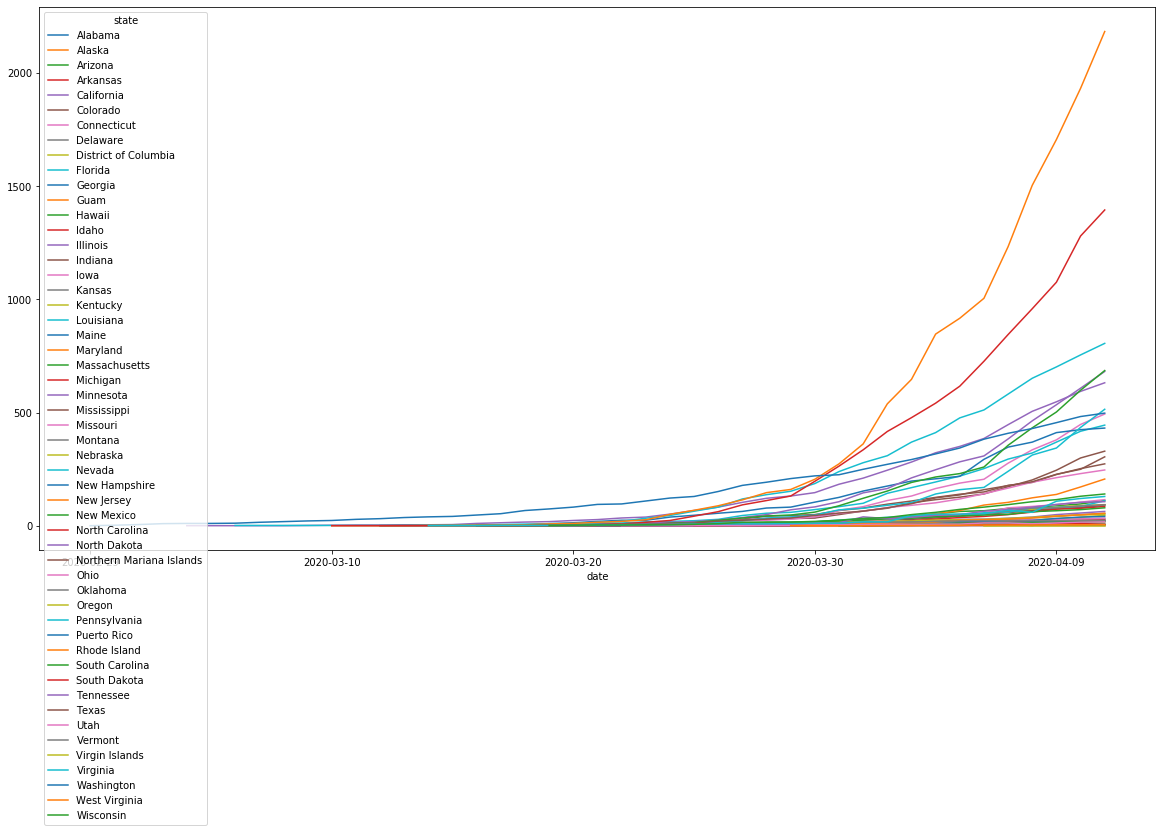

In [42]:
death_wo_NY = final_df[(final_df["Deaths"]>0) & (final_df["state"]!="New York")]
death_wo_NY = death_wo_NY.pivot( index="date",columns="state",values = "Deaths")
death_wo_NY.plot.line(figsize = (20,10))
plt.show

In [49]:
print(States_Most_Aggressive_Measures_df.head())
print(final_df.head())

   Overall Rank       State  Prevention & Containment Rank  \
0            48     Alabama                               48   
1             3      Alaska                                2   
2            39     Arizona                               36   
3            46    Arkansas                               45   
4            18  California                               15   

   Risk Factors & Infrastructure Rank  Economic Impact Rank  \
0                                    45                       2   
1                                    11                      40   
2                                    46                      19   
3                                    49                       5   
4                                    44                      16   

   Delta in Overall Rank vs. March 23  
0                                 -15  
1                                  11  
2                                  -1  
3                                   1  
4           

In [53]:
agg_time = pd.merge(final_df, States_Most_Aggressive_Measures_df, how = 'left', left_on = 'state', right_on = "State")
agg_time

,date,state,cases,Deaths,Overall Rank,State,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,2020-01-21,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
1,2020-01-22,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
2,2020-01-23,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
3,2020-01-24,Illinois,1,0,23.0,Illinois,25.0,16.0,48.0,-5.0
4,2020-01-24,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
...,...,...,...,...,...,...,...,...,...,...
2209,2020-04-11,New Mexico,1174,20,33.0,New Mexico,29.0,50.0,36.0,1.0
2210,2020-04-11,New York,180458,8627,1.0,New York,3.0,13.0,14.0,6.0
2211,2020-04-11,Georgia,12261,432,29.0,Georgia,30.0,40.0,4.0,12.0
2212,2020-04-11,Nebraska,729,18,49.0,Nebraska,49.0,20.0,8.0,-5.0


In [ ]:
top_botttom = 

In [60]:
df = pd.read_csv("CSV Folder/Poverty by state 2018.csv")
df.rename( columns={'Unnamed: 0':'State'}, inplace=True )
df.head()
pop_df = pd.read_csv("CSV Folder/SCPRC-EST2019-18+POP-RES.csv")
pop_df= pop_df[["NAME", "POPESTIMATE2019","POPEST18PLUS2019","PCNT_POPEST18PLUS"]]
pop_df = pop_df.rename(columns = {"NAME": "State","POPESTIMATE2019":"2019 Pop Est","POPEST18PLUS2019":"2019 18+","PCNT_POPEST18PLUS":"Percent 18+"})
pop_df.head()
poverty_df = pop_df.merge(df,how = 'inner',on = "State")
print(poverty_df.head(2))
tests_df.head(2)

     State  2019 Pop Est  2019 18+  Percent 18+  Percent in Poverty (All)  \
0  Alabama       4903185   3814879         77.8                      16.8   
1   Alaska        731545    551562         75.4                      11.1   

   90% CI Lower  90%CI Upper  Children ages 0-17 in Poverty  90% CI Lower.1  \
0          16.5         17.1                           23.9            23.2   
1          10.5         11.7                           14.5            13.4   

   90%CI Upper.1  
0           24.6  
1           15.6  


,State,positive,negative,pending,totalTestResults,recovered,hospitalizedCurrently,death
0,Alabama,5231,43295,NaN,48526,NaN,NaN,177.0
1,Alaska,329,10790,NaN,11119,168.0,42.0,9.0


In [61]:
pov_death = tests_df.merge(poverty_df,how = 'inner', on = "State")

In [71]:
pov_death.sort_values("death", ascending = False).head()

,State,positive,negative,pending,totalTestResults,recovered,hospitalizedCurrently,death,2019 Pop Est,2019 18+,Percent 18+,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1
31,New York,251690,397635,NaN,649325,23887.0,16076.0,14828.0,19453561,15425262,79.3,13.7,13.5,13.9,18.8,18.3,19.3
29,New Jersey,92387,92439,NaN,184826,NaN,7594.0,4753.0,8882190,6943612,78.2,9.5,9.3,9.7,13.5,12.9,14.1
21,Michigan,32967,84259,NaN,117226,3237.0,3357.0,2700.0,9986857,7842924,78.5,14.0,13.8,14.2,19.3,18.8,19.8
20,Massachusetts,41199,134173,NaN,175372,NaN,3872.0,1961.0,6892503,5539703,80.4,10.0,9.8,10.2,12.4,11.7,13.1
37,Pennsylvania,34528,132323,NaN,166851,NaN,2743.0,1564.0,12801989,10167376,79.4,12.2,12.0,12.4,16.7,16.2,17.2


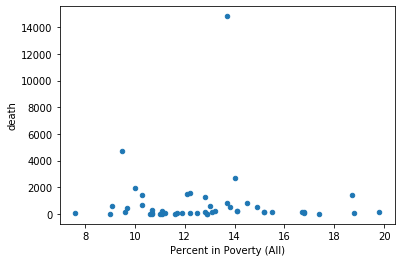

In [65]:
pov_death.plot.scatter("Percent in Poverty (All)","death")

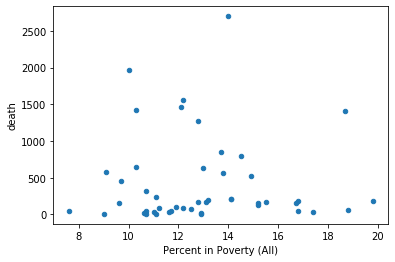

In [74]:
pov_wo_NY = pov_death[(pov_death["State"] != "New York")&(pov_death["State"] !="New Jersey")]
pov_wo_NY.plot.scatter("Percent in Poverty (All)","death")